# FINETUNE ON HF DATASET WITH SYLLABI

In [1]:
import transformers
import os
import json
from datasets import Dataset 

from datasets import load_dataset

dataset = load_dataset("anordkvist/gu-course-syllabus")['train']

In [2]:
from langdetect import detect

# Define your custom filtering function
def custom_filter(example):
    fields_to_check = ['Learning outcomes', 'Course content']
    blacklist_words = ['history', 'biology', 'music', 'art', 'philosophy', 'literature', 'psychology', 'sociology', 'economics', 'political science', 'politics']
    whitelist_words = ['IT engineering', 'IT', 'math', 'calculus', 'differential', 'machine learning', 'deep learning', 'maths', 'computer science', 'management', 'programming', 'robotics']
    
    # Check if the text is in English
    for field in fields_to_check:
        text = example[field].lower().strip().split()
        if detect(example[field]) != 'en':
            return False
        
        # Check for blacklist words
        for word in blacklist_words:
            if word in text:
                return False
        
        # Check for whitelist words
        for word in whitelist_words:
            if word in example[field]:
                return True
    
    # If no whitelist words are found, exclude the example
    return False

        

# Apply the filtering function to the dataset
filtered_dataset = dataset.filter(custom_filter)

In [3]:
filtered_dataset

Dataset({
    features: ['course_code', 'Confirmation', 'Position in the educational system', 'Entry requirements', 'Learning outcomes', 'Course content', 'Form of teaching', 'Assessment', 'Grades', 'Course evaluation', 'Additional information', '__index_level_0__'],
    num_rows: 631
})

In [4]:
def combine(example):
    s1 =  example['Learning outcomes'][example['Learning outcomes'].find(',') + 2:]
    new_feature_value =  s1 + '\n' + example['Course content']
    example['text'] = new_feature_value
    return example

filtered_dataset = filtered_dataset.map(combine)

In [5]:
fields_to_check = ['text']

# Get all column names
all_columns = filtered_dataset.column_names

# Remove the columns you want to keep from the list of all columns
columns_to_remove = [col for col in all_columns if col not in fields_to_check]

# Use the .remove_columns method to exclude these columns
dataset_processed = filtered_dataset.remove_columns(columns_to_remove)

dataset_processed

Dataset({
    features: ['text'],
    num_rows: 631
})

In [6]:
dataset_processed[0]

{'text': 'learning outcomes on successful completion of the course the student will be able to: knowledge and understanding •explain the lifecycle of data-intensive systems, starting from data creation, to validation, processing, presentation, storage, and archiving •explain the issues related to the integration of ai techniques in software systems, e.g., machine learning, data analysis, computer vision, or autonomous decision making •name and describe different common ai techniques and to which problems they are applicable •explain the impact of different data analysis goals on the required format, content, and quality of the data and the applicability of different ai techniques competence and skills •use common artificial intelligence techniques to solve pre-defined problems •apply techniques to validate and deploy data-intensive ai systems in the operational context judgement and approach •discuss the advantages and disadvantages of different patterns and architectures for data-inte

## Processing dataset

In [7]:
import transformers
import os
import json
from datasets import Dataset 

In [8]:
def load_data_from_folder(folder_path):
    data_files = os.listdir(folder_path)
    data = []
    for file_name in data_files:
        if file_name.lower().endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                item = json.load(file)
                data.append(item)
    return data

In [9]:
folder_path = os.path.join("..", "syllabuses")
data = load_data_from_folder(folder_path)
len(data)

61

In [10]:
data[0]

{'Title': 'Network And Cyber Security',
 'Short Description': 'This course covers the following concepts: Information Security Management; Web Security; Software Security; Network security.',
 'Prerequisites': {'Prerequisite subjects': [], 'Prerequisite topics': []},
 'Course Topics': [{'Section': 'Information Security Management',
   'Topics within the section': ['Security Policies and Controls',
    'Risks Analysis and Threats Modeling',
    'Software Development Security Techniques']},
  {'Section': 'Web Security',
   'Topics within the section': ['Security-related web technologies',
    'Same Origin Policy',
    'Web Attacker Model',
    'OWASP methodology',
    'Injection Flaws',
    'Authorization Flaws',
    'Cookies Flaws',
    'Server Misconfiguration']},
  {'Section': 'Software Security',
   'Topics within the section': ['Binary Exploitation', 'ASLR', 'NX']},
  {'Section': 'Network Security',
   'Topics within the section': ['Networking tools',
    'Network attacks',
    'IDS

In [11]:
def preprocess_course_data(data):
    def process(x):
        if (x.get('Title') and x.get('Short Description') and x.get('Course Topics') and
            x.get('Intended Learning Outcomes (ILOs)') and x.get('Formative Assessment and Course Activities')
           ):
            return ('TITLE: ' + x.get('Title').strip()+'\n'+'DESCRIPTION: '+  x.get('Short Description').strip()+
                    '\n'+'COURSE_TOPICS: '+str(x.get('Course Topics')) + '\n'
                   +'INTENDED_LEARNING_OUTCOMES: ' + str(x.get('Intended Learning Outcomes (ILOs)')) + '\n'
                   + 'FINAL_ASSESSMENT: ' + str(x.get('Formative Assessment and Course Activities')))
        return None

    return [process(x) for x in data if process(x)]

data_proc = preprocess_course_data(data)
dataset = Dataset.from_dict({"text": data_proc})
len(dataset)

56

In [12]:
dataset[0]['text']

"TITLE: Network And Cyber Security\nDESCRIPTION: This course covers the following concepts: Information Security Management; Web Security; Software Security; Network security.\nCOURSE_TOPICS: [{'Section': 'Information Security Management', 'Topics within the section': ['Security Policies and Controls', 'Risks Analysis and Threats Modeling', 'Software Development Security Techniques']}, {'Section': 'Web Security', 'Topics within the section': ['Security-related web technologies', 'Same Origin Policy', 'Web Attacker Model', 'OWASP methodology', 'Injection Flaws', 'Authorization Flaws', 'Cookies Flaws', 'Server Misconfiguration']}, {'Section': 'Software Security', 'Topics within the section': ['Binary Exploitation', 'ASLR', 'NX']}, {'Section': 'Network Security', 'Topics within the section': ['Networking tools', 'Network attacks', 'IDS/IPS']}]\nINTENDED_LEARNING_OUTCOMES: {'What is the main purpose of this course?': 'Security breaches cost billions of dollars worth of damage to the comput

In [13]:
datasetDict = dataset.train_test_split(train_size=0.7, shuffle=True, seed=42)
train_dataset_only_inno = datasetDict['train']
eval_dataset = datasetDict['test']

In [14]:
eval_dataset

Dataset({
    features: ['text'],
    num_rows: 17
})

In [15]:
from datasets import concatenate_datasets

In [16]:
# train_dataset = concatenate_datasets([train_dataset_only_inno])
train_dataset = concatenate_datasets([dataset_processed, train_dataset_only_inno])
train_dataset

Dataset({
    features: ['text'],
    num_rows: 670
})

## Define basic prompt for comparison between baseline & finetuned version

In [17]:
def sample_eval(model, tokenizer):
    model_params = {
        "max_new_tokens": 512,
    }
    with open("prompt_template_finetune.txt", "r", encoding='utf-8') as f:
        prompt_base = f.read()
    COURSE_NAME = "Statistical Techniques For Data Science and Robotics"
    COURSE_DESCRIPTION = "This advanced course covers main concepts in statics used in industry, including hypothesis testing, statistical tests, probabilitic and bayesian models."
    prompt_str = f"{prompt_base}\nCOURSE: {COURSE_NAME}\DESCRIPTION: {COURSE_DESCRIPTION}\nCOURSE_TOPICS: "
    chat = [
        { "role": "user", "content": prompt_str},
    ]
    prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    input_ids = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=input_ids.cuda(),
        **model_params,
    )
    response = tokenizer.decode(generated_ids[0])
    return response[len(prompt):]

Let's also try gemma 7b

In [18]:
# os.environ['HF_TOKEN'] = '<YOUR TOKEN>'

In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "google/gemma-1.1-2b-it"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

/home/mrudakov/.local/share/virtualenvs/AML-Project-RNdI0Dn9/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/mrudakov/.local/share/virtualenvs/AML-Project-RNdI0Dn9/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [20]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(prompt['text'])

#### Sample check on baseline model

In [21]:
result = sample_eval(model, tokenizer)
with open('gemma-2b-it-baseline-answer.txt', 'w') as f:
    f.write(result)

In [22]:
print(result)

```json
{
"Course": "Statistical Techniques For Data Science and Robotics",
"CourseDescription": "This course provides an introduction to statistical techniques commonly used in data science and robotics. Topics include hypothesis testing, statistical tests, probability and Bayesian models, and their applications in data analysis and model building."
"CourseTopics":
[
{
"Section": "Hypothesis Testing and Statistical Inference",
"Topics": ["Introduction to hypothesis testing", "Statistical inference", "Hypothesis testing procedures", "Confidence intervals"]
},
{
"Section": "Statistical Tests and Probability Theory",
"Topics": ["Statistical tests for means", "Statistical tests for variances", "Probability distributions", "Bayesian inference"]
},
{
"Section": "Bayesian Models and Decision Theory",
"Topics": ["Bayesian inference", "Bayes' theorem", "Decision theory", "Bayesian networks"]
},
{
"Section": "Advanced Topics in Statistical Techniques",
"Topics": ["Generalized linear models", "L

### Tokenization & preparation continued

In [23]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_eval_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

670


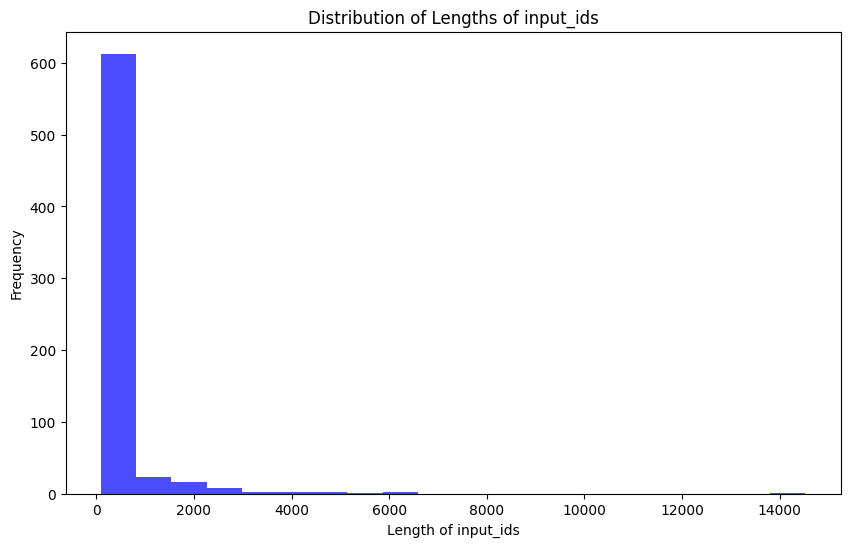

In [24]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset)

In [25]:
max_length = 1024 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        prompt['text'],
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [26]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_eval_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

In [27]:
print(tokenized_train_dataset[1]['input_ids'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [28]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [29]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [30]:
print(model)

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
    

In [31]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=4,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 5935104 || all params: 1521203200 || trainable%: 0.3901585271448285


In [32]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GemmaForCausalLM(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_l

In [34]:
import transformers
from datetime import datetime

output_dir = os.path.join('.', 'output')
os.environ['WANDB_PROJECT'] = 'syllabus-finetune'

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=30,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=200,
        learning_rate=2e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        # save_strategy="steps",       # Save the model checkpoint every logging step
        # save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=250,               # Evaluate and save checkpoints every 50 steps
        do_eval=False,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        # run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

max_steps is given, it will override any value given in num_train_epochs
/home/mrudakov/.local/share/virtualenvs/AML-Project-RNdI0Dn9/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


TrainOutput(global_step=200, training_loss=2.285608005523682, metrics={'train_runtime': 67.8251, 'train_samples_per_second': 2.949, 'train_steps_per_second': 2.949, 'total_flos': 2442632626176000.0, 'train_loss': 2.285608005523682, 'epoch': 0.29850746268656714})

In [35]:
import wandb
wandb.finish()

train/epoch,▁▂▁▂▃▄▅▆▇██
train/global_step,▁▂▁▂▃▄▅▆▇██
train/grad_norm,▆▆▁▆▄█▃▄▂▃
train/learning_rate,████▇▆▅▃▂▁
train/loss,█▄▃▂▂▂▁▁▁▁
total_flos,2442632626176000.0
train/epoch,0.29851
train/global_step,200
train/grad_norm,15.74681
train/learning_rate,0.0
train/loss,2.0853


## Save adapter

### Result after fine-tuning

In [36]:
with torch.no_grad():
    result = sample_eval(model, tokenizer)
    with open('gemma-2b-it-finetuned-answer.txt', 'w') as f:
        f.write(result)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/mrudakov/.local/share/virtualenvs/AML-Project-RNdI0Dn9/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.29 GiB. GPU 

In [36]:
result

'```json\n{\n"Course_Title": "Statistical Techniques for Data Science and Robotics",\n"Course_Description": "This course covers main concepts in statics used in industry, including hypothesis testing, statistical tests, probability and bayesian models.",\n"Course_Topics": [\n"Supervised Learning",\n"Decision Trees and Ensemble Methods",\n"Unsupervised Learning",\n"Deep Learning"\n]\n}\n```<eos>'

In [37]:
adapted_params = {}
for name, param in model.named_parameters():
  if 'lora' in name:  # This condition depends on how LORA parameters are named in your model
    adapted_params[name] = param.cpu().detach()

In [38]:
torch.save(adapted_params, 'gemma-1.1-2b-it-finetune.pth')

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "google/gemma-1.1-2b-it"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model2 = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

/home/mrudakov/.local/share/virtualenvs/AML-Project-RNdI0Dn9/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/mrudakov/.local/share/virtualenvs/AML-Project-RNdI0Dn9/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Load the saved parameters
adapted_params = torch.load('gemma-1.1-2b-it-finetune.pth')

# Assuming you have a fresh model instance
for name, param in adapted_params.items():
    print(name)
    continue
    # You might need to ensure the parameter names match exactly or adapt this logic to fit
    target_param = dict(model2.named_parameters())[name]
    with torch.no_grad():
        target_param.copy_(param)

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight
base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight
base_model.model.model.layers.0.mlp.gate_proj.lora_B.default.weight
base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight
base_model.model.model.layers.0.mlp.up_proj.lora_B.default.weight
base_model.model.model.layers.0.mlp.down_proj.lora_A.default.weight
base_model.model.model.layers.0.mlp.down_proj.lora_B.default.weight
base_model.model.model.layer